In [43]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
%matplotlib inline

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

In [2]:
data = pd.read_csv('/kaggle/input/faceexpression-dp/data.csv')
data.head()

,Unnamed: 0,path,label
0,0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,Surprise
1,1,Surprise/cropped_emotions.100096~12fffff.png,Surprise
2,2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,Surprise
3,3,Surprise/cropped_emotions.260779~12fffff.png,Surprise
4,4,Surprise/cropped_emotions.263616~12fffff.png,Surprise


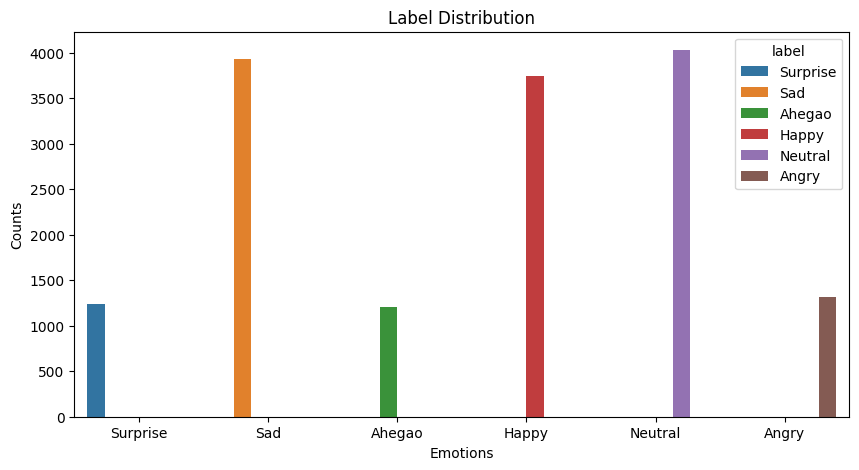

In [3]:
# Getting the label distribution
plt.figure(figsize=(10, 5))
plt.title("Label Distribution")
sns.countplot(data, x='label', hue='label')
plt.xlabel("Emotions")
plt.ylabel("Counts")
plt.show()

In [4]:
# convert the path to full path till the image
image_dir = "/kaggle/input/faceexpression-dp/dataset"

In [5]:
# Define Dataset parameters
TARGET_IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [6]:
image_datagen = ImageDataGenerator(
    rescale = 1./255.,
    validation_split = 0.2
)

#training the dataset
train_datagen = image_datagen.flow_from_directory(
    image_dir,
    target_size = TARGET_IMG_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    subset = 'training',
    shuffle = True
)

#testing the dataset
test_datagen = image_datagen.flow_from_directory(
    image_dir,
    target_size = TARGET_IMG_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    subset = 'training',
    shuffle = True
)

class_index = train_datagen.class_indices
index_class = {v:k for k, v in class_index.items()}

Found 12365 images belonging to 6 classes.
Found 12365 images belonging to 6 classes.


In [7]:
print(class_index)

{'Ahegao': 0, 'Angry': 1, 'Happy': 2, 'Neutral': 3, 'Sad': 4, 'Surprise': 5}


(32, 224, 224, 3)


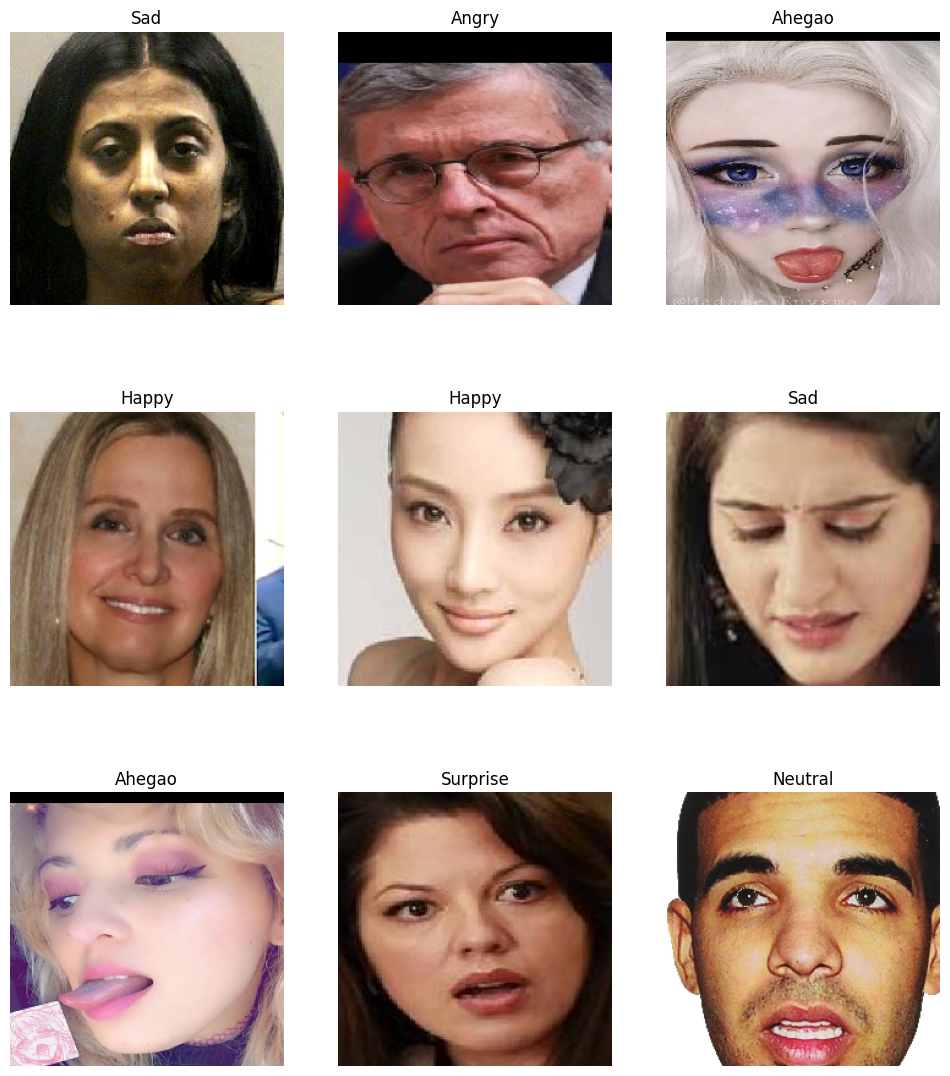

In [8]:
plt.figure(figsize=(12, 14))
for img, label in train_datagen:
    print(img.shape)
    label = np.argmax(label, axis=1)
    
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.title(f"{index_class[label[i]]}")
        plt.imshow(img[i])
        plt.axis('off')
    plt.show()
    break

In [9]:
pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-997esf0k
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-997esf0k
  Resolved https://github.com/rcmalli/keras-vggface.git to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8315 sha256=5bf56b0eee10cd4e3560b7bb1adf4bcdff38fab6f7206da8dc9c96c040115d77
  Stored in directory: /tmp/pip-ephem-wheel-cache-1pz0ssdv/wheels/62/cd/e0/3a2d2fe84d014324aed54d420cab52df65a774d9b296c63996
Successfully built keras-vggface
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install Keras-Applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [11]:
# check version of keras_vggface
import keras_vggface
from keras_vggface.vggface import VGGFace
# print version
print(keras_vggface.__version__)

0.6


In [12]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model

def create_model(img_shape, num_classes, fine_tune = 0, drop_out=0.1):
    vgg_model = VGGFace(model = 'vgg16',weights='vggface',include_top=False, input_shape=img_shape, pooling = 'avg')
    # Freeze all the layers
    for layer in vgg_model.layers:
        layer.trainable = False
    
    # Unfreeze certain layers
    if fine_tune != 0:
        for layer in vgg_model.layers[fine_tune:]:
            layer.trainable = True
    
    
    base_model_output = vgg_model.output
    
    dropout1 = Dropout(drop_out)(base_model_output)
    dense1 = Dense(128, activation='relu')(dropout1)
    dropout2 = Dropout(drop_out)(dense1)
    output = Dense(num_classes, activation='softmax')(dropout2)
    
    return Model(inputs=vgg_model.input, outputs=output)

In [13]:
model = create_model((*TARGET_IMG_SIZE, 3), 6)

58909280/58909280 [==============================] - 1s 0us/step


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [15]:
oup = model(img[:2])
print(oup.shape)

(2, 6)


In [19]:
checkpoint = ModelCheckpoint("models/face_expression_new.h5",
                            monitor="val_loss",
                            mode="min",
                            save_best_only=True)

earlystop = EarlyStopping(monitor='val_loss',
                         restore_best_weights=True,
                         patience=5)

Reducing_LR = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3)

callbacks = [earlystop, checkpoint,Reducing_LR]

In [17]:
model.compile(loss='categorical_crossentropy',
                        optimizer=Adam(learning_rate=0.00001),
                        metrics=['accuracy'])

In [20]:
EPOCHS = 15
history = model.fit(train_datagen, epochs=EPOCHS, validation_data=test_datagen, callbacks=callbacks)

Epoch 1/15
387/387 [==============================] - 198s 490ms/step - loss: 1.7719 - accuracy: 0.2790 - val_loss: 1.7558 - val_accuracy: 0.3237 - lr: 1.0000e-05
Epoch 2/15
387/387 [==============================] - 149s 384ms/step - loss: 1.7400 - accuracy: 0.3262 - val_loss: 1.7225 - val_accuracy: 0.3715 - lr: 1.0000e-05
Epoch 3/15
387/387 [==============================] - 149s 385ms/step - loss: 1.7075 - accuracy: 0.3577 - val_loss: 1.6917 - val_accuracy: 0.4106 - lr: 1.0000e-05
Epoch 4/15
387/387 [==============================] - 150s 389ms/step - loss: 1.6795 - accuracy: 0.3774 - val_loss: 1.6662 - val_accuracy: 0.4438 - lr: 1.0000e-05
Epoch 5/15
387/387 [==============================] - 145s 375ms/step - loss: 1.6572 - accuracy: 0.3963 - val_loss: 1.6458 - val_accuracy: 0.4691 - lr: 1.0000e-05
Epoch 6/15
387/387 [==============================] - 147s 380ms/step - loss: 1.6386 - accuracy: 0.4182 - val_loss: 1.6291 - val_accuracy: 0.4838 - lr: 1.0000e-05
Epoch 7/15
387/387 [==

In [21]:
model.save("model.keras")

In [25]:
# Method to plot the train performance
def plot_training_performance(history, metrics):
    plt.figure(figsize=(14, 12))
    
    for i, metrics in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        val_metrics = "val_" + metrics
        
        plt.title(f"{metrics} vs {val_metrics}")
        plt.plot(history.history[metrics], label=metrics)
        plt.plot(history.history[val_metrics], label=val_metrics)
        plt.grid(True)
        plt.xlabel("Epochs")
        plt.ylabel(metrics)
        plt.legend()
    
    plt.show()

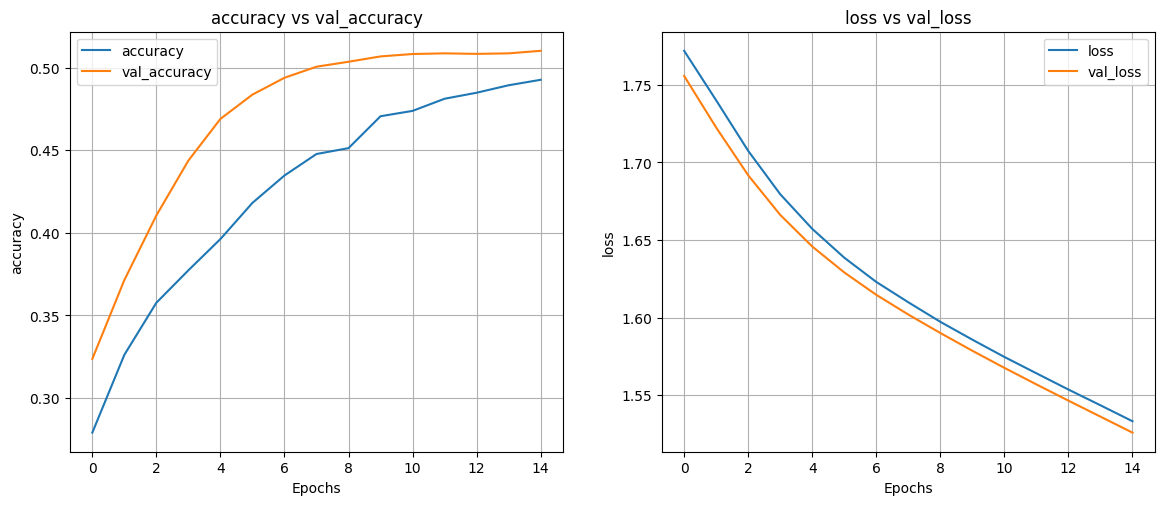

In [26]:
plot_training_performance(history, ['accuracy', 'loss'])

From above graph it can be deduced that my model is neither overfitting nor underfitting it was generally not performing well.

In [27]:
# Method to plot the confusion matrix
def plot_confusion_matrix(conf_mat, labels):
    plt.title("Confusion Matrix", {'size': 16})
    sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Prediction")
    plt.ylabel("True value")
    plt.show()

In [28]:
# Method to plot ROC Curve for Multi-class
def plot_roc_curve(y_true, y_pred, labels):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for idx, label in enumerate(labels):
        fpr[label], tpr[label], _ = roc_curve(y_true[:, idx], y_pred[:, idx])
        roc_auc[label] = auc(fpr[label], tpr[label])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # PLot the ROC curve
    plt.plot(fpr["micro"], tpr["micro"], label=f"ROC Micro (area = {roc_auc['micro']:.2f})")

    for label in labels:
        plt.plot(fpr[label], tpr[label], label=f"ROC for {label} (area = {roc_auc[label]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label='No Skills')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Face Expressions", {'size': 16})
    plt.legend()

In [35]:
def predictions(model, dataset):
    y_true_proba = []
    y_pred_proba = []
    total_batches = dataset.n // dataset.batch_size
    for indx, (img, label) in enumerate(dataset):
        if indx > total_batches:
            break
        preds = model.predict(img, verbose=0)
        y_true_proba.extend(label)
        y_pred_proba.extend(preds)

    y_true_proba = np.array(y_true_proba)
    y_pred_proba = np.array(y_pred_proba)

    return (y_true_proba, y_pred_proba)

In [36]:
true_probs, pred_probs = predictions(model, test_datagen)

In [37]:
true_labels = np.argmax(true_probs, axis=1)
pred_labels = np.argmax(pred_probs, axis=1)

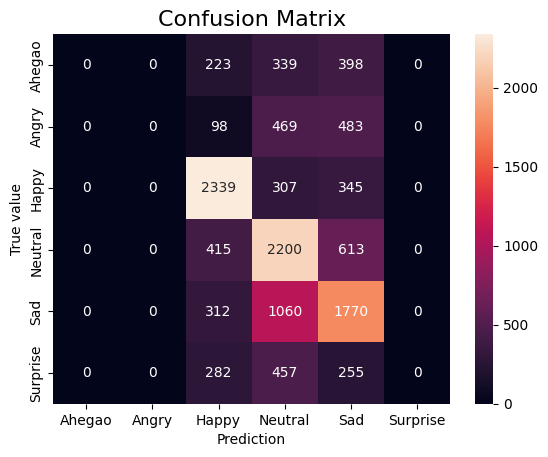

In [40]:
conf_matrix = confusion_matrix(true_labels, pred_labels)
labels = list(train_datagen.class_indices.keys())
plot_confusion_matrix(conf_matrix, labels)

In [41]:
clf_report = classification_report(true_labels, pred_labels, target_names=labels)
print(clf_report)

              precision    recall  f1-score   support

      Ahegao       0.00      0.00      0.00       960
       Angry       0.00      0.00      0.00      1050
       Happy       0.64      0.78      0.70      2991
     Neutral       0.46      0.68      0.55      3228
         Sad       0.46      0.56      0.51      3142
    Surprise       0.00      0.00      0.00       994

    accuracy                           0.51     12365
   macro avg       0.26      0.34      0.29     12365
weighted avg       0.39      0.51      0.44     12365



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


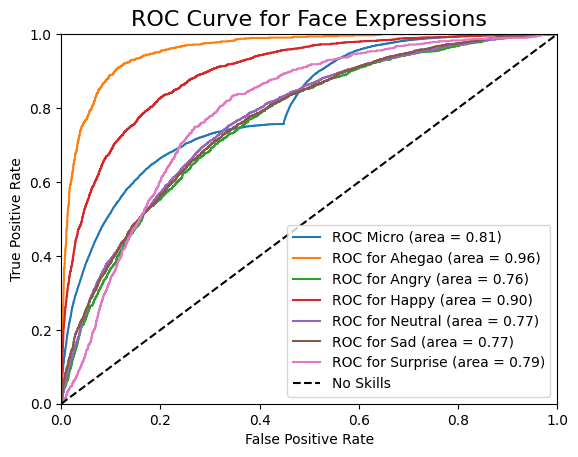

In [42]:
plot_roc_curve(true_probs, pred_probs, labels)

Although, the model is not that well, it is pretty confident in what it predicts which is nice thing. Now for the rest half we will unfreeze the pretrained model entirely and retrain the while model over the dataset to make it adapt to the dataset.

In [44]:
model.save('model.keras')

In [45]:
model2 = tf.keras.models.load_model('model.keras')

In [46]:
# unfreeze all the layers of the model2
for layer in model2.layers:
    layer.trainable = True

In [47]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [48]:
checkpoint = ModelCheckpoint("models/face_expression_new.h5",
                            monitor="val_loss",
                            mode="min",
                            save_best_only=True)

earlystop = EarlyStopping(monitor='val_loss',
                         restore_best_weights=True,
                         patience=5)

Reducing_LR = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3)

callbacks = [earlystop, checkpoint,Reducing_LR]

In [49]:
model2.compile(loss='categorical_crossentropy',
                        optimizer=Adam(learning_rate=1e-6),
                        metrics=['accuracy'])

In [50]:
EPOCHS = 15
hist2 = model2.fit(train_datagen, epochs=EPOCHS, validation_data=test_datagen, callbacks=callbacks)

Epoch 1/15
387/387 [==============================] - 249s 618ms/step - loss: 1.2624 - accuracy: 0.5412 - val_loss: 0.9360 - val_accuracy: 0.6547 - lr: 1.0000e-06
Epoch 2/15
387/387 [==============================] - 236s 610ms/step - loss: 0.8969 - accuracy: 0.6510 - val_loss: 0.7673 - val_accuracy: 0.7085 - lr: 1.0000e-06
Epoch 3/15
387/387 [==============================] - 235s 608ms/step - loss: 0.7988 - accuracy: 0.6897 - val_loss: 0.7002 - val_accuracy: 0.7363 - lr: 1.0000e-06
Epoch 4/15
387/387 [==============================] - 235s 608ms/step - loss: 0.7522 - accuracy: 0.7114 - val_loss: 0.6553 - val_accuracy: 0.7544 - lr: 1.0000e-06
Epoch 5/15
387/387 [==============================] - 236s 610ms/step - loss: 0.7020 - accuracy: 0.7309 - val_loss: 0.6152 - val_accuracy: 0.7717 - lr: 1.0000e-06
Epoch 6/15
387/387 [==============================] - 233s 603ms/step - loss: 0.6653 - accuracy: 0.7458 - val_loss: 0.5771 - val_accuracy: 0.7872 - lr: 1.0000e-06
Epoch 7/15
387/387 [==

As can be seen that the model has drastcially improved. So let us see it over the testing dataset

In [51]:
model2.save('model.keras')

In [52]:
true_probs, pred_probs = predictions(model2, test_datagen)

In [53]:
true_labels = np.argmax(true_probs, axis=1)
pred_labels = np.argmax(pred_probs, axis=1)

In [54]:
clf_report = classification_report(true_labels, pred_labels, target_names=labels)
print(clf_report)

              precision    recall  f1-score   support

      Ahegao       0.94      0.96      0.95       962
       Angry       0.80      0.78      0.79      1061
       Happy       0.97      0.94      0.95      2984
     Neutral       0.76      0.83      0.79      3220
         Sad       0.81      0.78      0.79      3150
    Surprise       0.84      0.77      0.80       988

    accuracy                           0.84     12365
   macro avg       0.85      0.84      0.85     12365
weighted avg       0.85      0.84      0.84     12365



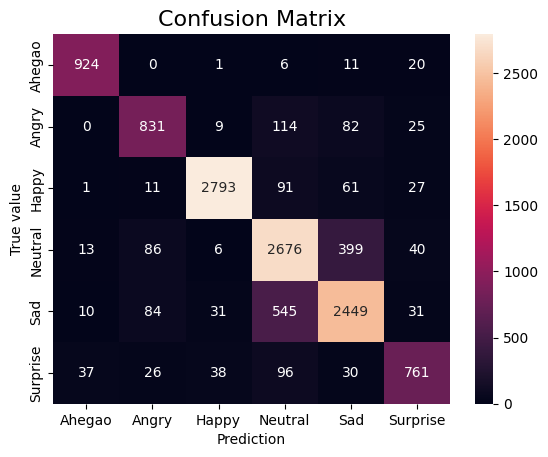

In [55]:
conf_matrix = confusion_matrix(true_labels, pred_labels)
labels = list(train_datagen.class_indices.keys())
plot_confusion_matrix(conf_matrix, labels)

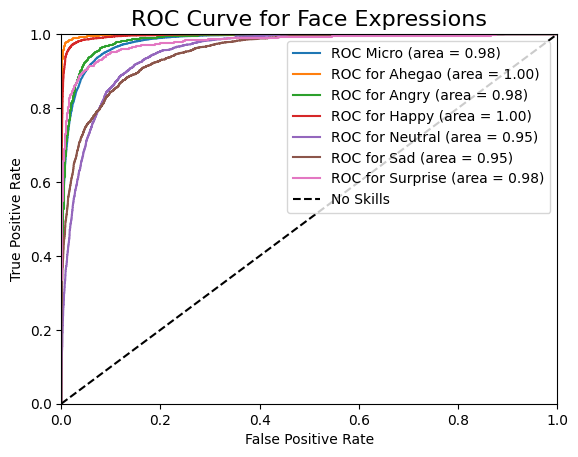

In [56]:
plot_roc_curve(true_probs, pred_probs, labels)